In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
pd.options.display.float_format = '{:.3f}'.format

In [4]:
df_micro_0e1 = pd.read_csv('/content/drive/MyDrive/RESULTADOS MERGE 2/REMOVENDO NaN C0 E 50% RFRegressor VALORES C1 (ELIMINANDO OUTLIERS COM ISOLATION FOREST)/MICROCYSTIS sp./Cópia de DF-BASE_microcystis.csv')
df_micro_0e1

,Delta T,TempAr,SolSuspensaoTotais,SolDissolvidosTotais,TempAmostra,SolTotais,pH,Turbidez,OD,Resultado,...,Nome do manancial superficial,Date_x,Município,Classe,Verao,Outono,Inverno,Primavera,Região Geográfica,Outlier
0,4.900,20.000,26.000,57.000,15.100,83.000,6.500,25.900,7.400,0.000,...,RIO CAMANDUCAIA,2019-08-12,EXTREMA,0,0,0,1,0,SUDESTE,1
1,2.000,16.000,3.000,24.000,14.000,27.000,6.000,2.870,8.000,0.000,...,RIO CAMANDUCAIA,2019-08-12,EXTREMA,0,0,0,1,0,SUDESTE,1
2,4.100,21.000,76.000,40.000,16.900,116.000,7.100,44.500,8.400,0.000,...,RIO CAMANDUCAIA,2020-05-19,EXTREMA,0,0,1,0,0,SUDESTE,1
3,1.100,15.700,8.000,26.000,14.600,34.000,7.700,2.340,8.100,0.000,...,RIO CAMANDUCAIA,2020-05-19,EXTREMA,0,0,1,0,0,SUDESTE,1
4,2.200,24.900,115.000,93.000,22.700,208.000,6.500,154.000,7.000,0.000,...,CONQUISTA,2018-03-05,ALPINOPOLIS,0,1,0,0,0,SUDESTE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,2.600,30.500,7.000,298.000,27.900,305.000,7.900,10.000,7.300,21547.000,...,RIO JAGUARIBE,2018-09-24,ARNEIROZ,1,0,0,0,1,NORDESTE,1
1590,1.900,29.400,9.000,238.000,27.500,247.000,8.500,46.700,9.600,21547.000,...,RIO JAGUARIBE,2018-09-24,ARNEIROZ,1,0,0,0,1,NORDESTE,1
1591,-2.800,26.900,4.000,180.000,29.700,184.000,8.600,6.700,7.800,21547.000,...,RIO JAGUARIBE,2018-09-24,ARNEIROZ,1,0,0,0,1,NORDESTE,1
1592,-1.300,30.100,13.000,172.000,31.400,185.000,8.700,6.600,11.800,21547.000,...,RIO JAGUARIBE,2018-09-24,ARNEIROZ,1,0,0,0,1,NORDESTE,1


In [5]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Lista de tamanhos de teste
test_sizes = np.arange(0.2, 0.31, 0.01)

# DataFrames para armazenar os resultados
feature_importances_mean_df = pd.DataFrame()
ranked_features_df = pd.DataFrame(columns=["Test_Size", "Ranked_Features"])

# Iterar sobre os tamanhos de teste
for test_size in test_sizes:
    # Divisão dos dados
    X = df_micro_0e1.drop(['Classe', 'Resultado', 'UF', 'Unidade', 'Categoria do manancial superficial', 'Nome do manancial superficial', 'Date_x', 'Município', 'Região Geográfica', 'Outlier'], axis=1)
    y=  df_micro_0e1['Classe']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Treinamento do modelo
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Coletando importâncias das features
    feature_importances = rf_model.feature_importances_

    # Armazenando as importâncias para a média
    temp_df = pd.DataFrame({
        "Feature": X.columns,
        f"Importance_{test_size:.2f}": feature_importances
    })
    if feature_importances_mean_df.empty:
        feature_importances_mean_df = temp_df
    else:
        feature_importances_mean_df = feature_importances_mean_df.merge(temp_df, on="Feature", how="inner")

    # Criando string de ranking das features
    ranked_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
    ranked_features_str = ", ".join([f"{i + 1} - {feat[0]} ({feat[1]:.4f})" for i, feat in enumerate(ranked_features)])

    # Adicionando ao DataFrame de ranking
    ranked_features_df = pd.concat([ranked_features_df, pd.DataFrame({"Test_Size": [test_size], "Ranked_Features": [ranked_features_str]})], ignore_index=True)

# Calculando a média das importâncias para o primeiro DataFrame
importance_mean_cols = [col for col in feature_importances_mean_df.columns if "Importance" in col]
feature_importances_mean_df["Mean_Importance"] = feature_importances_mean_df[importance_mean_cols].mean(axis=1)

# Criando o DataFrame final com apenas Feature e Mean_Importance
final_importance_mean_df = feature_importances_mean_df[["Feature", "Mean_Importance"]].sort_values(by="Mean_Importance", ascending=False)

final_importance_mean_df.reset_index(drop=True)

<ipython-input-5-4526199e873a>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ranked_features_df = pd.concat([ranked_features_df, pd.DataFrame({"Test_Size": [test_size], "Ranked_Features": [ranked_features_str]})], ignore_index=True)


,Feature,Mean_Importance
0,Verao,0.151
1,OD,0.127
2,SolSuspensaoTotais,0.115
3,Turbidez,0.096
4,pH,0.090
5,SolDissolvidosTotais,0.090
6,SolTotais,0.076
7,TempAmostra,0.076
8,Delta T,0.071
9,TempAr,0.070


In [6]:
ranked_features_df

,Test_Size,Ranked_Features
0,0.200,"1 - Verao (0.1391), 2 - OD (0.1213), 3 - SolSu..."
1,0.210,"1 - Verao (0.1510), 2 - OD (0.1274), 3 - SolSu..."
2,0.220,"1 - Verao (0.1457), 2 - OD (0.1316), 3 - SolSu..."
3,0.230,"1 - Verao (0.1532), 2 - OD (0.1334), 3 - SolSu..."
4,0.240,"1 - Verao (0.1529), 2 - OD (0.1221), 3 - SolSu..."
5,0.250,"1 - Verao (0.1516), 2 - OD (0.1281), 3 - SolSu..."
6,0.260,"1 - Verao (0.1495), 2 - OD (0.1183), 3 - SolSu..."
7,0.270,"1 - Verao (0.1524), 2 - OD (0.1277), 3 - SolSu..."
8,0.280,"1 - Verao (0.1534), 2 - OD (0.1268), 3 - SolSu..."
9,0.290,"1 - Verao (0.1479), 2 - OD (0.1319), 3 - SolSu..."


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

# Lista para armazenar os resultados de importância de cada iteração
resultados_importancia = []

# Loop para diferentes tamanhos de treino
for train_size in [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8]:
    # Dividir os dados em conjuntos de treino e temporário (validação + teste)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)

    # Calcular o tamanho do conjunto de teste com base no tamanho do conjunto de treino e validação (0.1 fixo)
    test_size = (1 - train_size - 0.1) / (1 - train_size)

    # Dividir o conjunto temporário em conjuntos de validação e teste
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size, stratify=y_temp, random_state=42)

    # Treinar o modelo Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Calcular a importância por permutação usando F1-score
    perm_importance = permutation_importance(rf_model, X_test, y_test, scoring="f1", random_state=42, n_repeats=20, n_jobs=-1)

    # Organizar os resultados em um dataframe
    perm_importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Permutation Importance (Mean)": perm_importance.importances_mean,
        "Permutation Importance (Std)": perm_importance.importances_std
    }).sort_values(by="Permutation Importance (Mean)", ascending=False)

    # Adicionar os resultados à lista
    resultados_importancia.append(perm_importance_df)

    print(f'terminei tamanho de treino {train_size}')

# Criar um dataframe vazio para armazenar a média e o desvio padrão da importância das features
media_importancia_df = pd.DataFrame({"Feature": X.columns})
media_importancia_df["Mean Importance"] = 0.0
media_importancia_df["Std Importance"] = 0.0

# Calcular a média e o desvio padrão da importância das features para cada iteração
for importancia_df in resultados_importancia:
    importancia_map_mean = importancia_df.set_index("Feature")["Permutation Importance (Mean)"].to_dict()
    importancia_map_std = importancia_df.set_index("Feature")["Permutation Importance (Std)"].to_dict()

    # Somar os valores alinhados pela feature
    media_importancia_df["Mean Importance"] += media_importancia_df["Feature"].map(importancia_map_mean)
    media_importancia_df["Std Importance"] += media_importancia_df["Feature"].map(importancia_map_std)**2

# Finalizar o cálculo da média e do desvio padrão
media_importancia_df["Mean Importance"] /= len(resultados_importancia)
media_importancia_df["Std Importance"] = (media_importancia_df["Std Importance"] / len(resultados_importancia))**0.5

# Ordenar o dataframe pela média da importância
media_importancia_df = media_importancia_df.sort_values(by="Mean Importance", ascending=False)

# Exibir o dataframe com a média e o desvio padrão da importância das features
media_importancia_df

terminei tamanho de treino 0.7
terminei tamanho de treino 0.71
terminei tamanho de treino 0.72
terminei tamanho de treino 0.73
terminei tamanho de treino 0.74
terminei tamanho de treino 0.75
terminei tamanho de treino 0.76
terminei tamanho de treino 0.77
terminei tamanho de treino 0.78
terminei tamanho de treino 0.79
terminei tamanho de treino 0.8


,Feature,Mean Importance,Std Importance
9,Verao,0.337,0.065
2,SolSuspensaoTotais,0.196,0.060
8,OD,0.082,0.034
3,SolDissolvidosTotais,0.067,0.026
0,Delta T,0.035,0.027
1,TempAr,0.005,0.021
7,Turbidez,0.005,0.022
12,Primavera,0.004,0.011
10,Outono,0.002,0.007
11,Inverno,0.001,0.007


In [9]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Cria o dataframe para armazenar os resultados
resultados_rfe = pd.DataFrame(columns=['Train Size', 'Nomes das Features Selecionadas'])
X = df_micro_0e1.drop(['Classe', 'Resultado', 'UF', 'Unidade', 'Categoria do manancial superficial', 'Nome do manancial superficial', 'Date_x', 'Município', 'Região Geográfica', 'Outlier'], axis=1)
y = df_micro_0e1['Classe']
for train_size in np.arange(0.7, 0.8, 0.01):
    # Divide os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)

    # Cria o estimador base
    estimator = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, bootstrap=False)

    # Define o número de features a serem selecionadas
    n_features_selecionadas = 7

    # Cria o seletor RFE
    selector = RFE(estimator, n_features_to_select=n_features_selecionadas, step=1)

    # Treina o RFE SOMENTE nos dados de TREINO
    selector = selector.fit(X_train, y_train)

    # Obtém as features selecionadas (USANDO OS NOMES DAS COLUNAS DO DATAFRAME)
    features_selecionadas = X_train.columns[selector.support_].tolist()

    # Adiciona os resultados ao DataFrame
    resultados_rfe = pd.concat([resultados_rfe, pd.DataFrame({'Train Size': [train_size],
                                                              'Nomes das Features Selecionadas': [features_selecionadas]})],
                                ignore_index=True)

# Imprime a tabela formatada
#print(resultados_rfe)

# Para salvar em um arquivo CSV (opcional)
#resultados_rfe.to_csv('resultados_rfe_nomes.csv', index=False)

#Exibindo os dados de forma mais legível
for index, row in resultados_rfe.iterrows():
    print(f"Train Size: {row['Train Size']:.2f}")
    print(f"Nomes das Features Selecionadas: {row['Nomes das Features Selecionadas']}")
    print("-" * 30)

<ipython-input-9-ac8c1e7b79f4>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_rfe = pd.concat([resultados_rfe, pd.DataFrame({'Train Size': [train_size],


Train Size: 0.70
Nomes das Features Selecionadas: ['Delta T', 'SolSuspensaoTotais', 'SolDissolvidosTotais', 'pH', 'Turbidez', 'OD', 'Verao']
------------------------------
Train Size: 0.71
Nomes das Features Selecionadas: ['SolSuspensaoTotais', 'SolDissolvidosTotais', 'TempAmostra', 'pH', 'Turbidez', 'OD', 'Verao']
------------------------------
Train Size: 0.72
Nomes das Features Selecionadas: ['Delta T', 'SolSuspensaoTotais', 'SolDissolvidosTotais', 'pH', 'Turbidez', 'OD', 'Verao']
------------------------------
Train Size: 0.73
Nomes das Features Selecionadas: ['Delta T', 'SolSuspensaoTotais', 'SolDissolvidosTotais', 'SolTotais', 'Turbidez', 'OD', 'Verao']
------------------------------
Train Size: 0.74
Nomes das Features Selecionadas: ['Delta T', 'SolSuspensaoTotais', 'SolDissolvidosTotais', 'pH', 'Turbidez', 'OD', 'Verao']
------------------------------
Train Size: 0.75
Nomes das Features Selecionadas: ['Delta T', 'SolSuspensaoTotais', 'SolDissolvidosTotais', 'SolTotais', 'Turbide

# RANDOM FOREST - PREVISÃO

FOI TESTADO NO MODELO PURO DE 0,7 ATÉ 0,8 DE DADOS NO TREINAMENTO.

*   0,22 FOI O MELHOR

A MESMA COISA FOI FEITA COM VALIDAÇÃO/TESTE

*   0,55 PARA TESTE DENTRE OS O,22 FOI O MELHOR (0,12 DO TOTAL E 0,1 PARA VALIDAÇÃO, SOBRANDO 0,78 PARA TREINO)





## Modelo puro

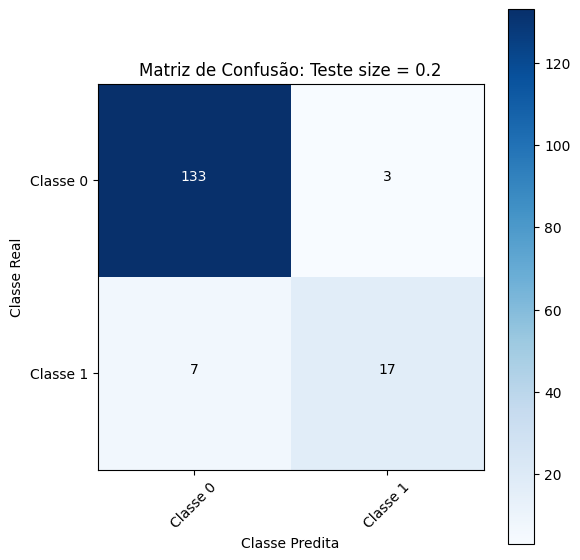

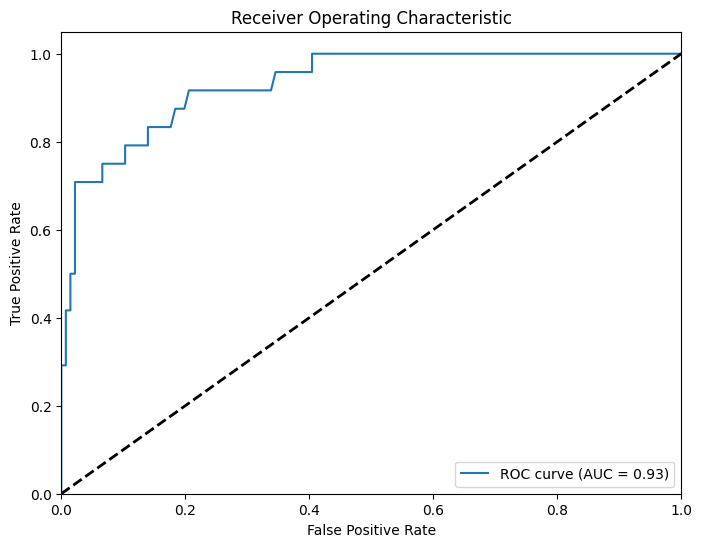

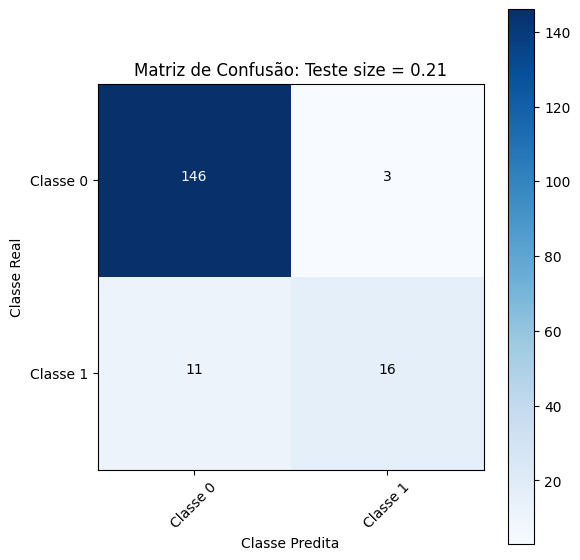

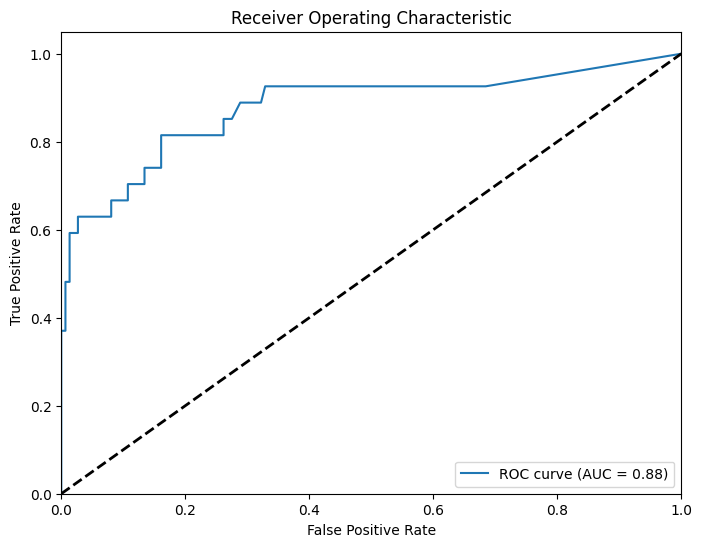

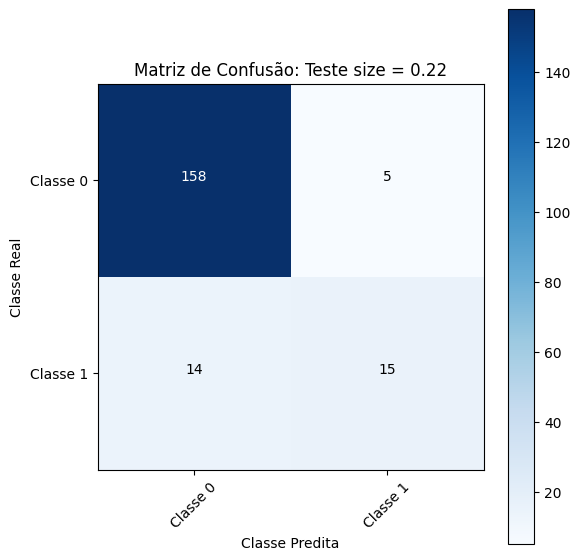

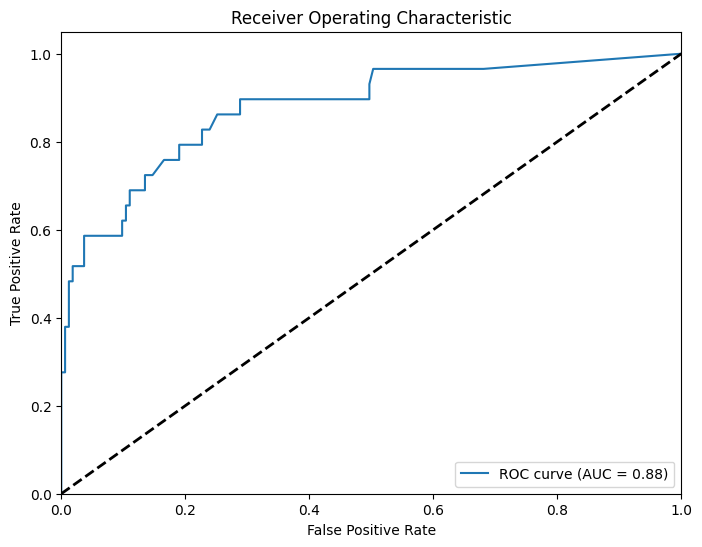

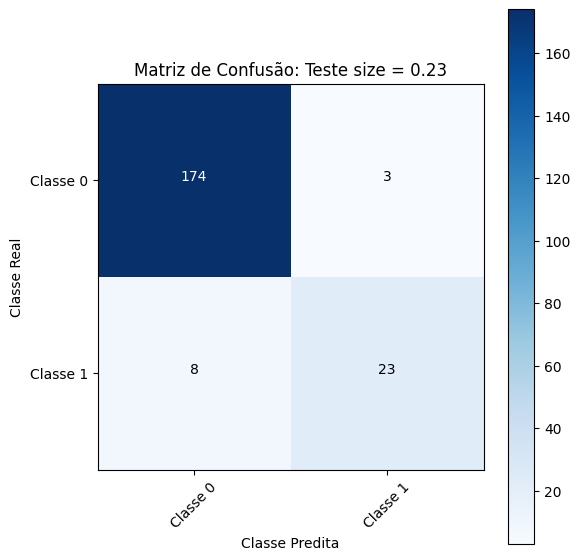

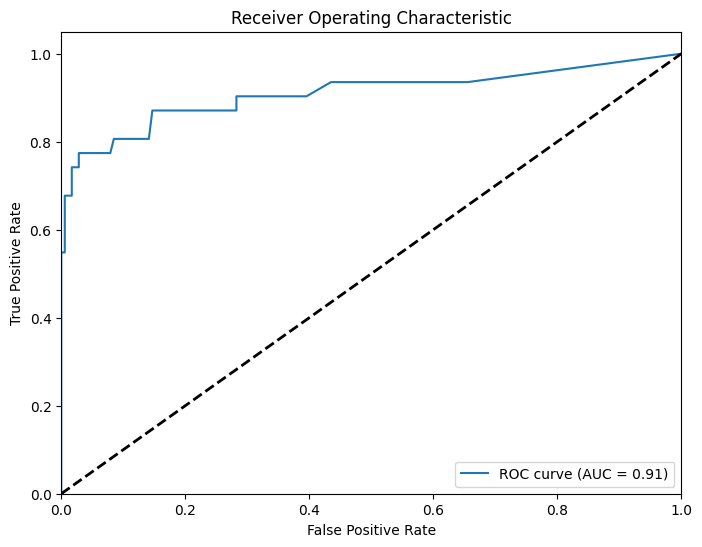

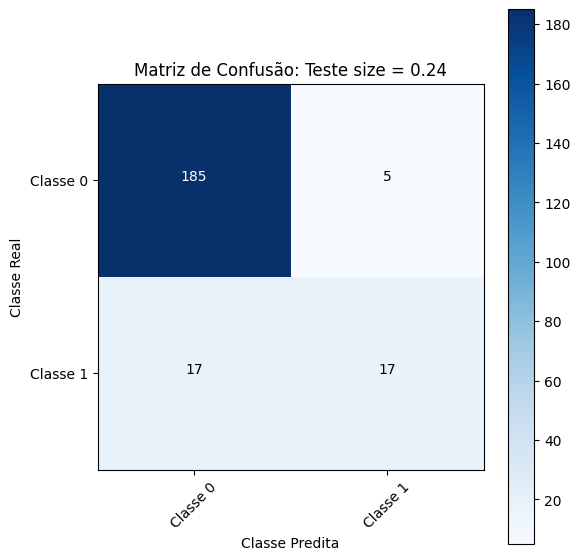

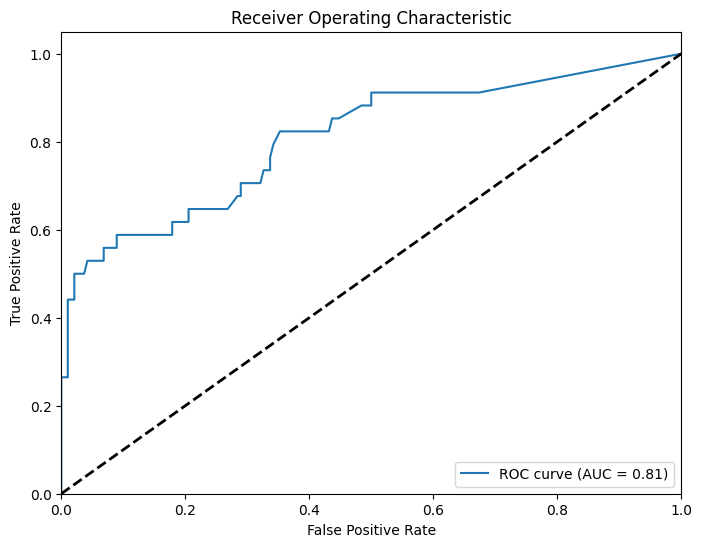

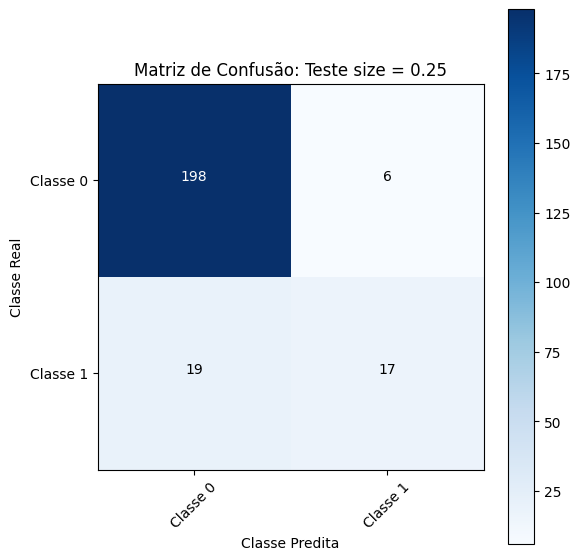

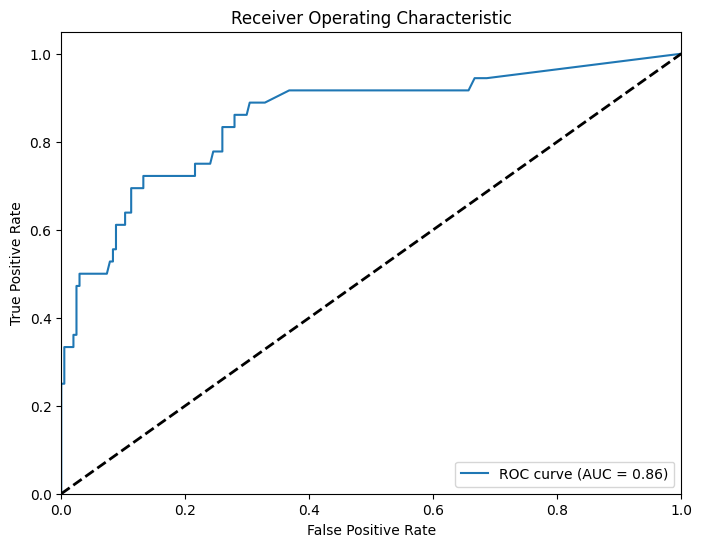

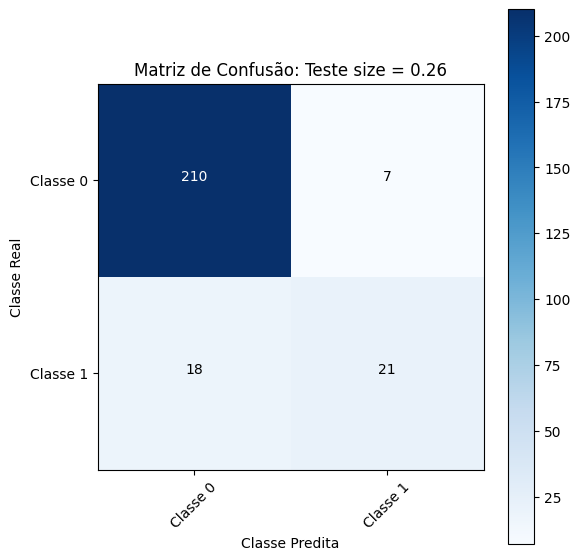

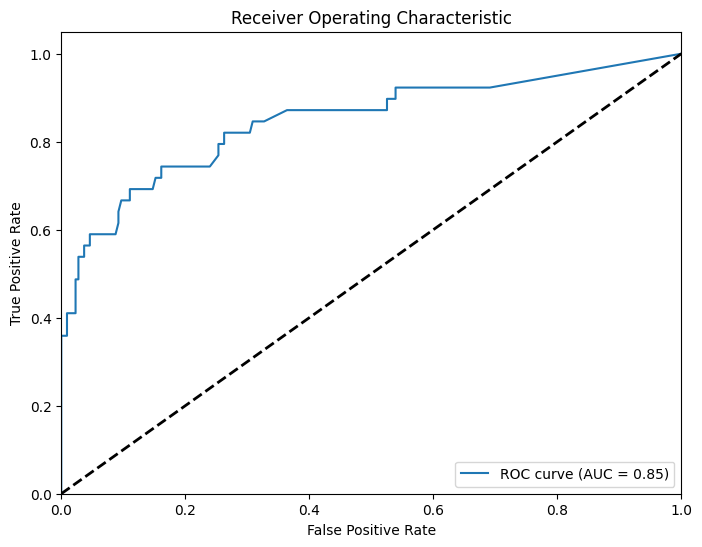

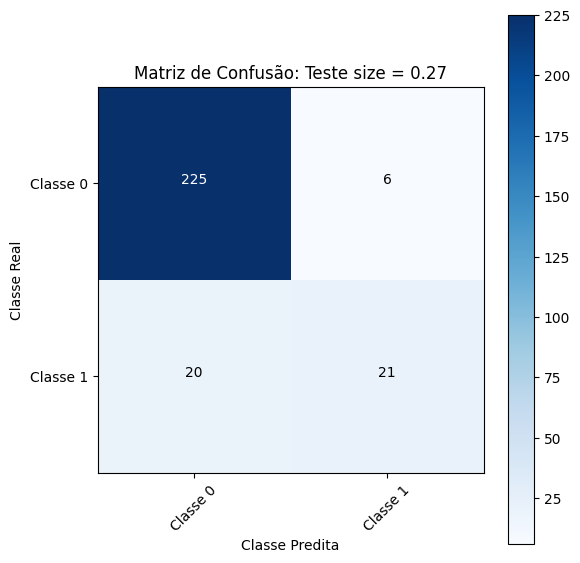

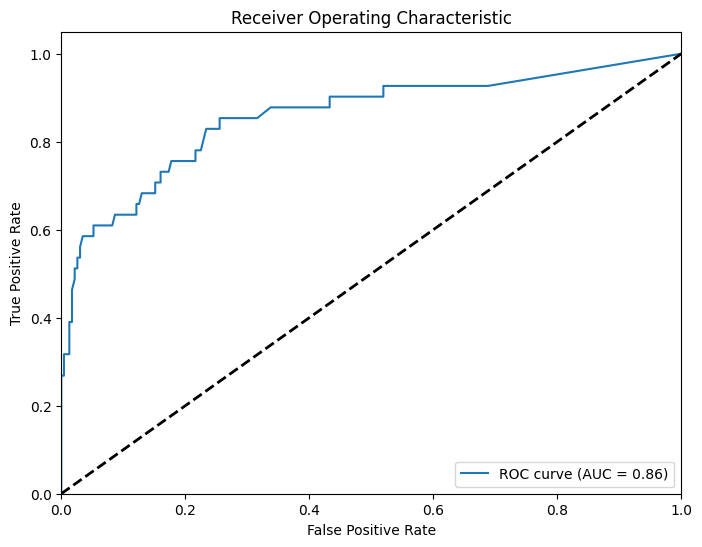

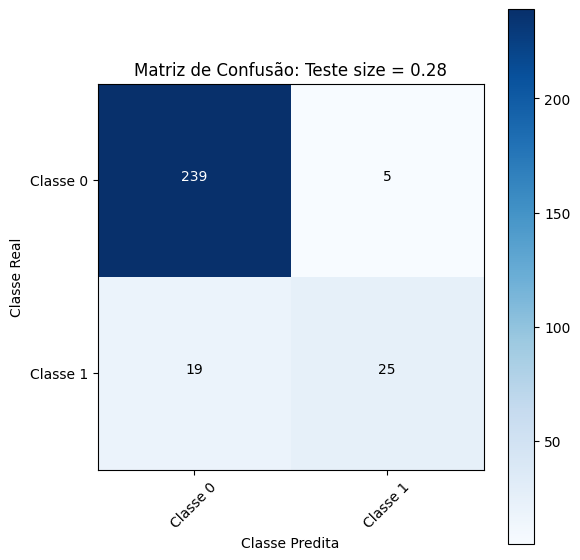

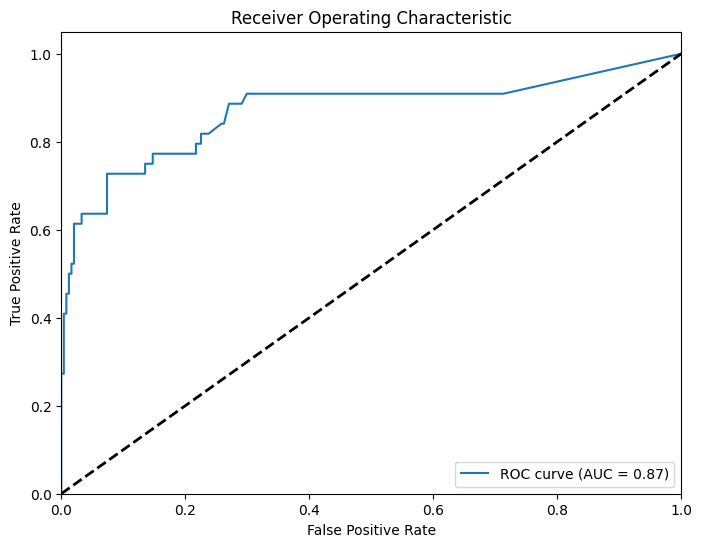

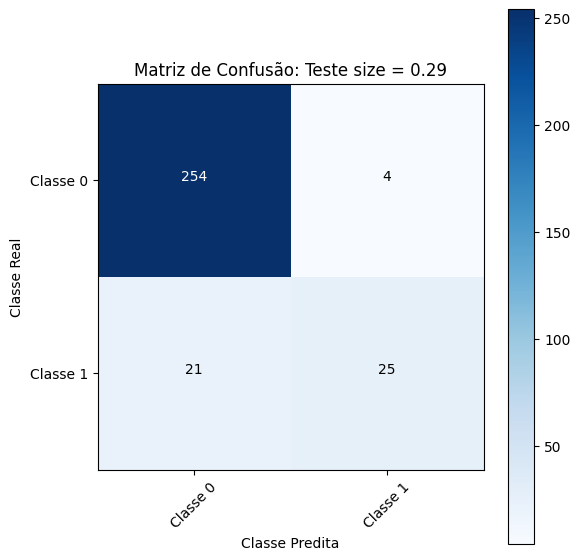

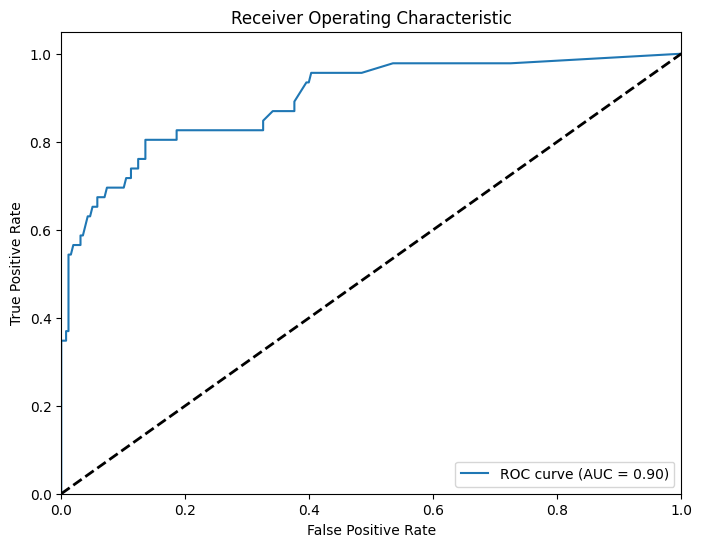

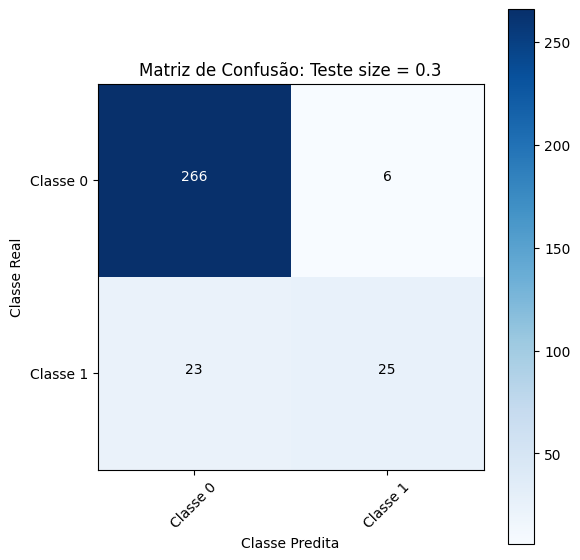

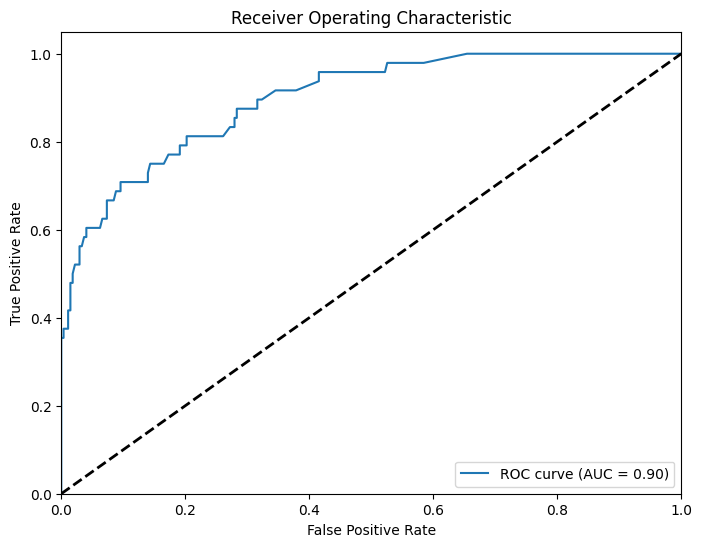

,Amostragem N,Teor Treino,Teor Teste,Teor Validação,Precisão C1,Recall C1,Métrica_F1 C1,ROC-AUC index,Cross_Validation_Score
3,31.000,0.770,0.130,0.100,0.885,0.742,0.807,0.909,0.635
0,24.000,0.800,0.100,0.100,0.850,0.708,0.773,0.933,0.610
1,27.000,0.790,0.110,0.100,0.842,0.593,0.696,0.878,0.632
8,44.000,0.720,0.180,0.100,0.833,0.568,0.676,0.870,0.616
9,46.000,0.710,0.190,0.100,0.862,0.543,0.667,0.896,0.654
10,48.000,0.700,0.200,0.100,0.806,0.521,0.633,0.898,0.615
6,39.000,0.740,0.160,0.100,0.750,0.538,0.627,0.848,0.625
7,41.000,0.730,0.170,0.100,0.778,0.512,0.618,0.857,0.613
2,29.000,0.780,0.120,0.100,0.750,0.517,0.612,0.878,0.630
4,34.000,0.760,0.140,0.100,0.773,0.500,0.607,0.809,0.648


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

lista_precision = []
lista_f1 = []
lista_amostra_n = []
lista_recall = []
lista_teste_size = []
lista_rocauc = []
lista_teor_treino = []
lista_teor_validacao = []
lista_cross_val_mean = []  # Nova lista para armazenar a média dos scores do Cross Validation

# Features fixas
fixed_features = ['Verao', 'SolDissolvidosTotais', 'Turbidez', 'pH', 'Delta T']

# Selecionar features e classe
X = df_micro_0e1[fixed_features]
y = df_micro_0e1['Classe']

for TSize in [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]:
    # Dividir os dados
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TSize, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/TSize), stratify=y_temp, random_state=42)

    # Configurar o modelo
    rf_model = RandomForestClassifier(random_state=42)

    # Validação Cruzada no conjunto de treino
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')  # Usando F1-score
    mean_cv_score = np.mean(cv_scores)
    lista_cross_val_mean.append(mean_cv_score)

    # Treinar o modelo
    rf_model.fit(X_train, y_train)

    # Previsões no conjunto de teste
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

    # Matriz de Confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão: Teste size = {str(TSize)}')
    plt.colorbar()
    classes = ['Classe 0', 'Classe 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()
    plt.show()

    # Curva ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Curva ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Relatório de Classificação
    results = {
        'AUC': roc_auc,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

    lista_precision.append(results['Classification Report']['1']['precision'])
    lista_recall.append(results['Classification Report']['1']['recall'])
    lista_f1.append(results['Classification Report']['1']['f1-score'])
    lista_amostra_n.append(results['Classification Report']['1']['support'])
    lista_teste_size.append((TSize)*(1-(0.1/TSize)))
    lista_teor_treino.append(1-TSize)
    lista_rocauc.append(results['AUC'])
    lista_teor_validacao.append(TSize*(0.1/TSize))

# Criar o DataFrame final
df_final_metricas = pd.DataFrame()
df_final_metricas['Amostragem N'] = pd.DataFrame(lista_amostra_n)
df_final_metricas['Teor Treino'] = pd.DataFrame(lista_teor_treino)
df_final_metricas['Teor Teste'] = pd.DataFrame(lista_teste_size)
df_final_metricas['Teor Validação'] = pd.DataFrame(lista_teor_validacao)
df_final_metricas['Precisão C1'] = pd.DataFrame(lista_precision)
df_final_metricas['Recall C1'] = pd.DataFrame(lista_recall)
df_final_metricas['Métrica_F1 C1'] = pd.DataFrame(lista_f1)
df_final_metricas['ROC-AUC index'] = pd.DataFrame(lista_rocauc)
df_final_metricas['Cross_Validation_Score'] = pd.DataFrame(lista_cross_val_mean)  # Adicionar CV score

# Ordenar pelo F1-Score
df_final_metricas.sort_values(by='Métrica_F1 C1', ascending=False)

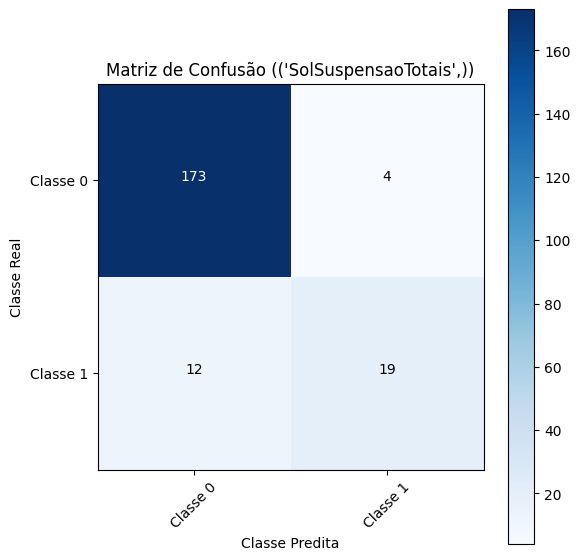

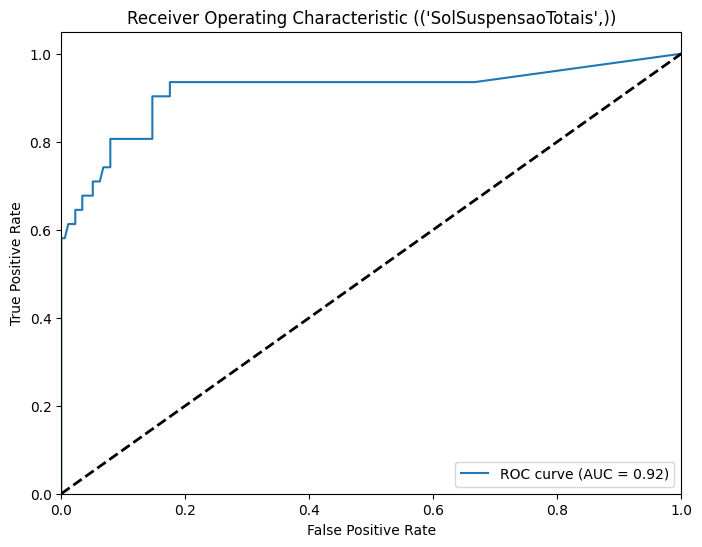

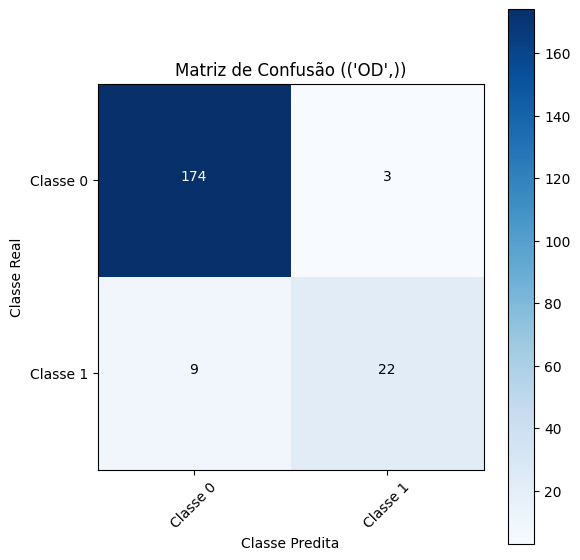

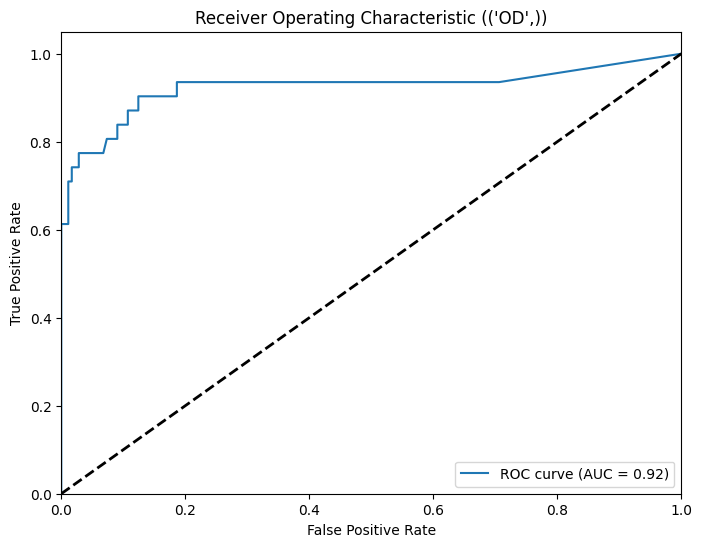

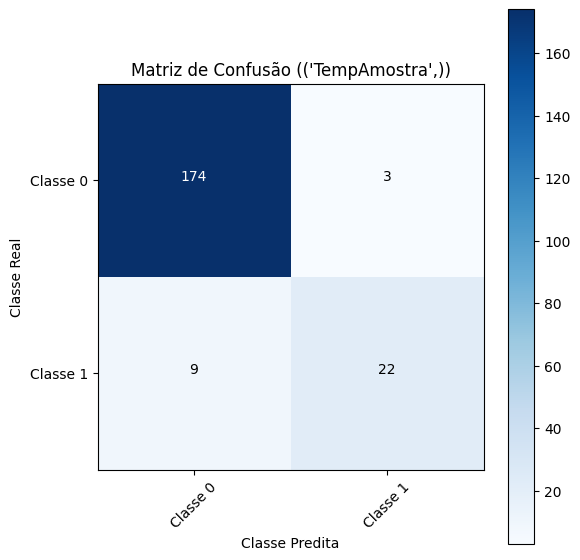

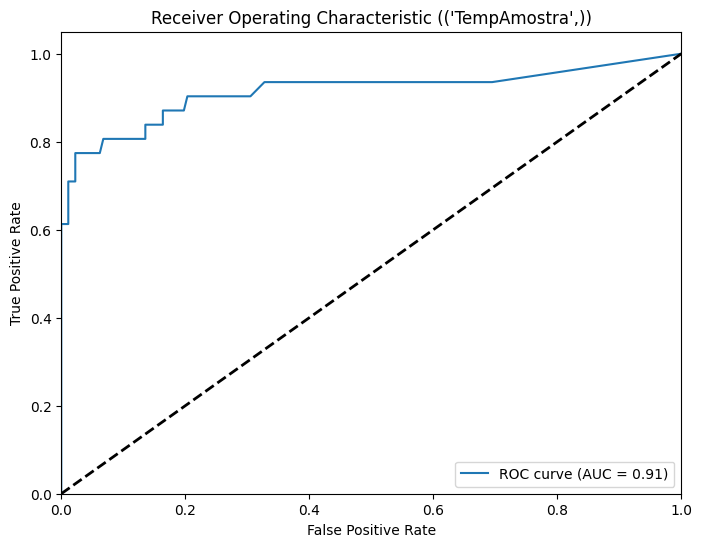

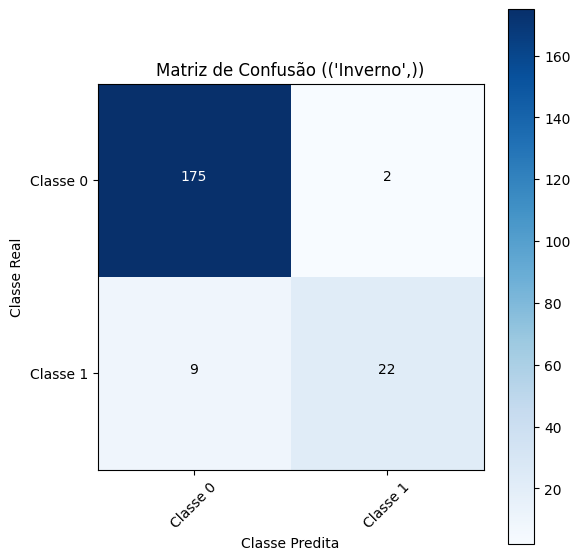

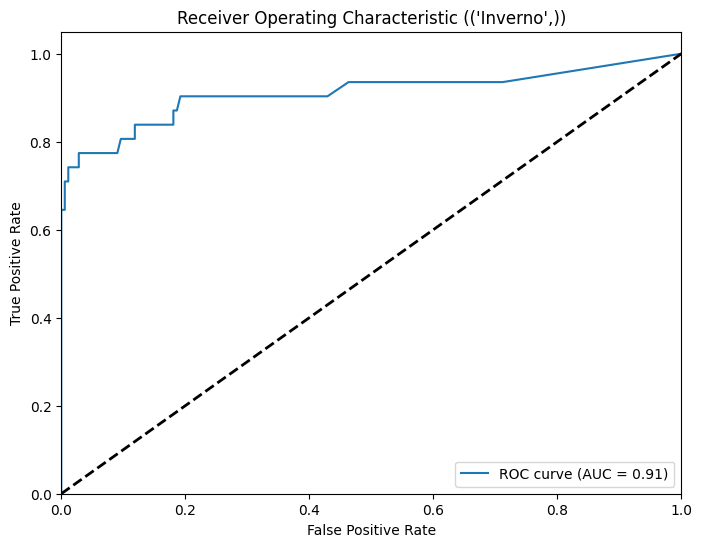

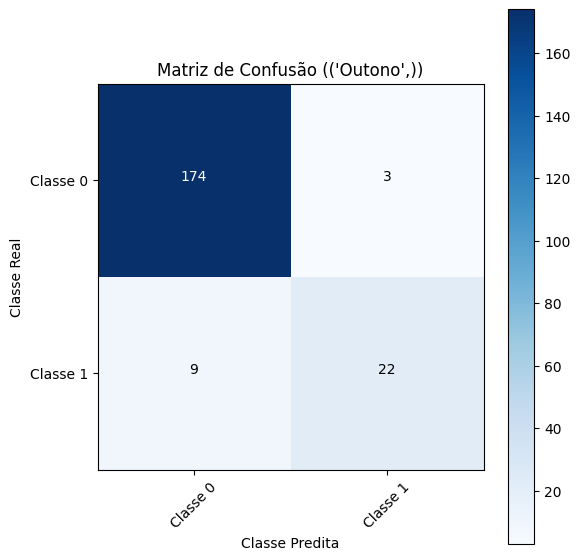

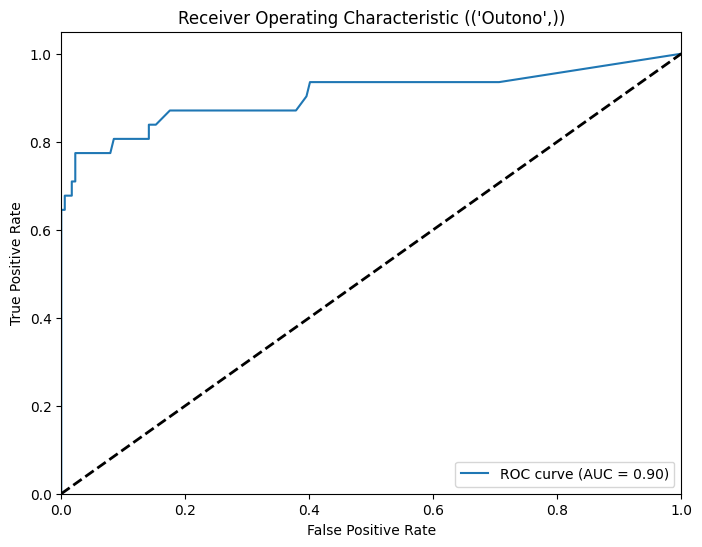

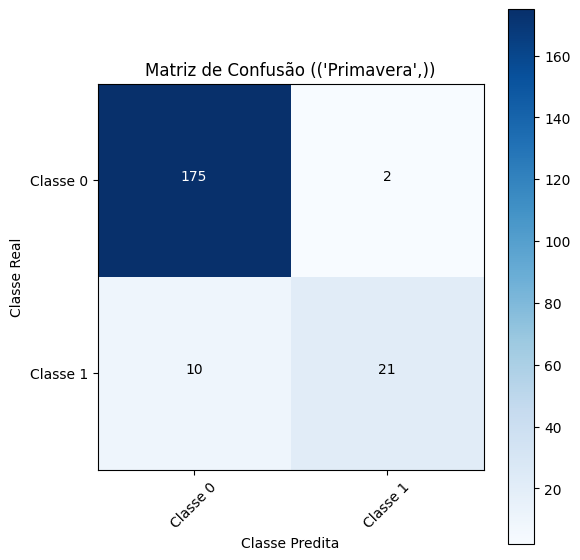

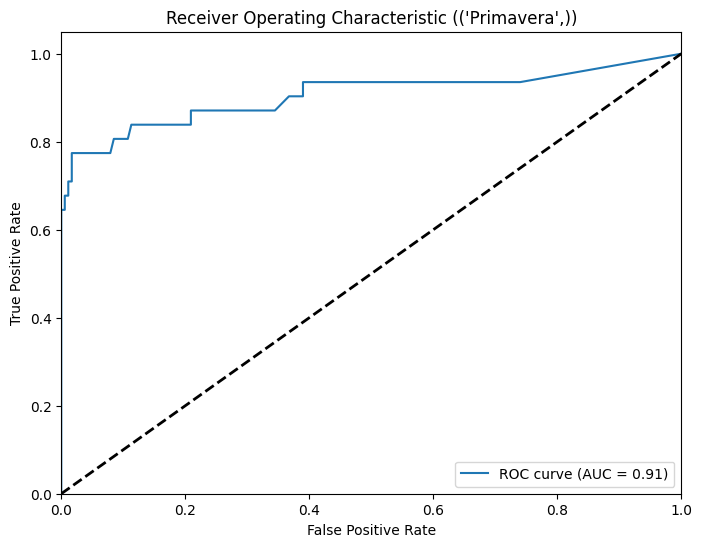

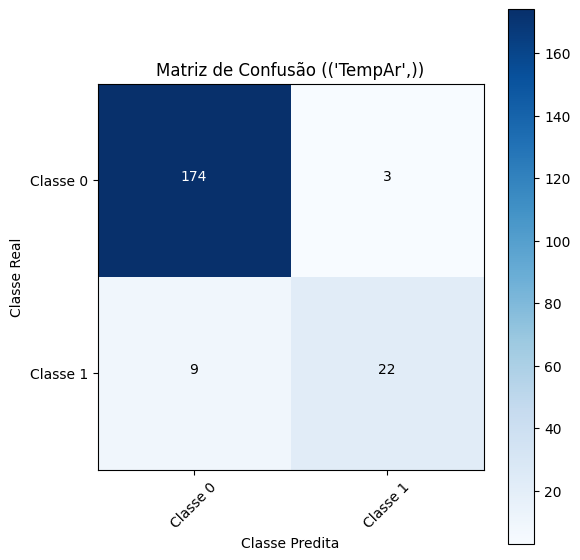

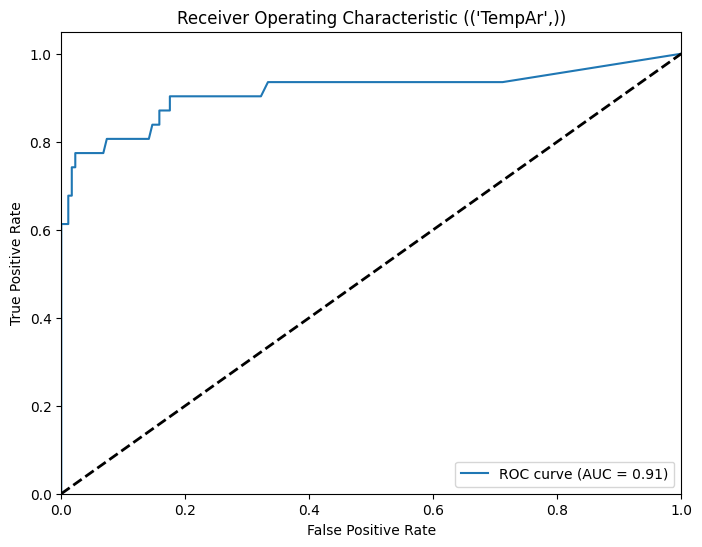

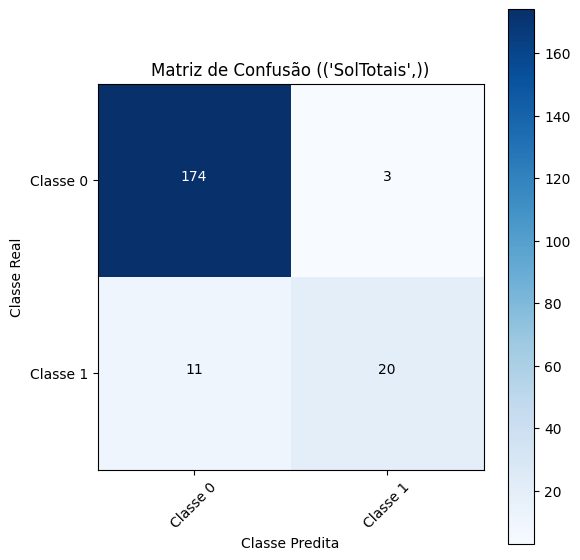

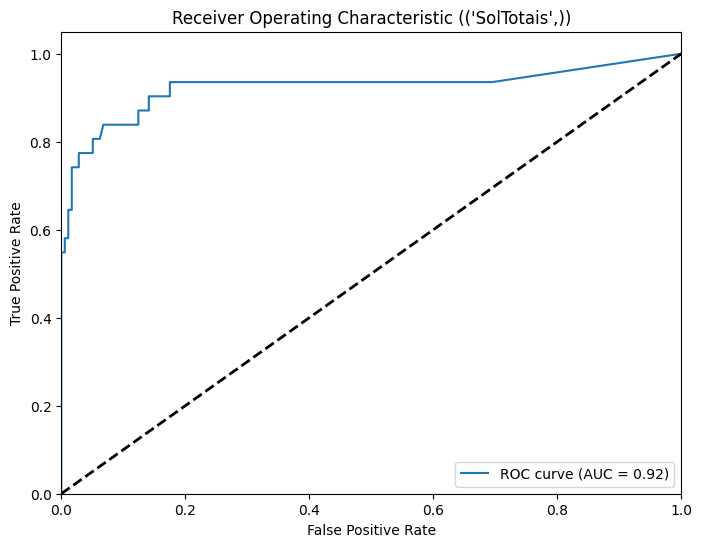

,Feature,Amostragem N,Teor Treino,Teor Teste,Teor Validação,Precisão C1,Recall C1,Métrica_F1 C1,ROC-AUC index,Cross_Validation_Score
3,Inverno,31.000,0.770,0.130,0.100,0.917,0.710,0.800,0.910,0.646
1,OD,31.000,0.770,0.130,0.100,0.880,0.710,0.786,0.924,0.660
2,TempAmostra,31.000,0.770,0.130,0.100,0.880,0.710,0.786,0.914,0.650
4,Outono,31.000,0.770,0.130,0.100,0.880,0.710,0.786,0.905,0.624
6,TempAr,31.000,0.770,0.130,0.100,0.880,0.710,0.786,0.914,0.641
5,Primavera,31.000,0.770,0.130,0.100,0.913,0.677,0.778,0.905,0.646
7,SolTotais,31.000,0.770,0.130,0.100,0.870,0.645,0.741,0.924,0.652
0,SolSuspensaoTotais,31.000,0.770,0.130,0.100,0.826,0.613,0.704,0.915,0.663


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import cross_val_score

lista_precision = []
lista_f1 = []
lista_amostra_n = []
lista_recall = []
lista_teste_size = []
lista_rocauc = []
lista_teor_treino = []
lista_teor_validacao = []
lista_cross_val_mean = []
lista_features = []

# Features fixas e variáveis para combinações
fixed_features = ['Verao', 'SolDissolvidosTotais', 'Turbidez', 'pH', 'Delta T']
variable_features = perm_importance_df[~perm_importance_df['Feature'].isin(fixed_features)]['Feature']

# Para armazenar os resultados
results = []
i=0
# Loop pelas combinações das variáveis
for comb in itertools.combinations(variable_features, 1):
    selected_features = fixed_features + list(comb)
    X = df_micro_0e1[selected_features]
    y = df_micro_0e1['Classe']

    # Dividir os dados
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1-(0.1/0.23)), stratify=y_temp, random_state=42)

    # Configurar o modelo
    rf_model = RandomForestClassifier(random_state=42)

    # Treinar o modelo
    rf_model.fit(X_train, y_train)

    # Validação Cruzada no conjunto de treino
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')  # Usando F1-score
    mean_cv_score = np.mean(cv_scores)
    lista_cross_val_mean.append(mean_cv_score)

    # Previsões no conjunto de teste
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

    # Matriz de Confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão ({comb})')
    plt.colorbar()
    classes = ['Classe 0', 'Classe 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()
    plt.show()

    # Curva ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({comb})')
    plt.legend(loc="lower right")
    plt.show()

    # Armazenar resultados
    results.append({
        'Combination': comb,
        'AUC': roc_auc,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    })
    report = results[-1]['Classification Report']  # Acessa o último relatório armazenado
    precision = report.get('1', {}).get('precision', 0)
    recall = report.get('1', {}).get('recall', 0)
    f1 = report.get('1', {}).get('f1-score', 0)
    support = report.get('1', {}).get('support', 0)
    roc_auc = results[-1]['AUC']
    lista_f1.append(f1)
    lista_precision.append(precision)
    lista_recall.append(recall)
    lista_amostra_n.append(support)
    lista_teste_size.append((0.23)*(1-(0.1/0.23)))
    lista_teor_treino.append(0.77)
    lista_rocauc.append(roc_auc)
    lista_teor_validacao.append(0.1)
    i=i+1

# Criar o DataFrame final
df_final_metricas = pd.DataFrame()
df_final_metricas = pd.DataFrame({
    'Feature': variable_features.to_list(),
    'Amostragem N': lista_amostra_n,
    'Teor Treino': lista_teor_treino,
    'Teor Teste': lista_teste_size,
    'Teor Validação': lista_teor_validacao,
    'Precisão C1': lista_precision,
    'Recall C1': lista_recall,
    'Métrica_F1 C1': lista_f1,
    'ROC-AUC index': lista_rocauc,
    'Cross_Validation_Score': lista_cross_val_mean,
})

# Ordenar pelo F1-Score
df_final_metricas.sort_values(by='Métrica_F1 C1', ascending=False)

## SMOTE PURO

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross Validation Scores: [0.91222571 0.9153605  0.9153605  0.9153605  0.87421384]
Cross Validation Mean Accuracy: 0.9065
Relatório de Classificação por Classe:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       177
           1       0.64      0.74      0.69        31

    accuracy                           0.90       208
   macro avg       0.80      0.83      0.81       208
weighted avg       0.91      0.90      0.90       208



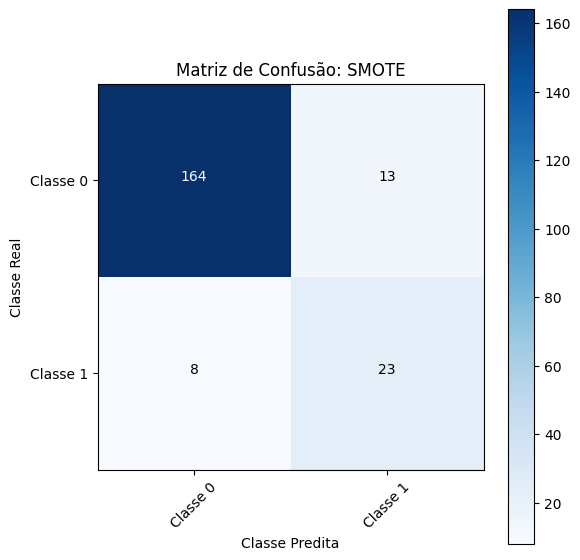

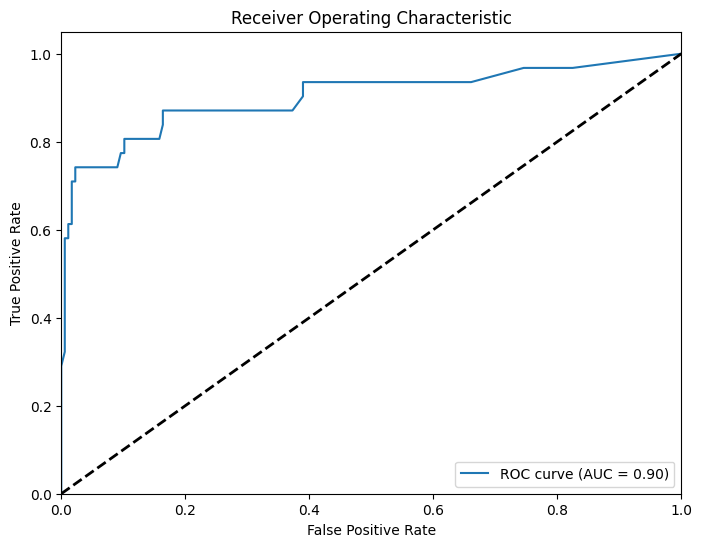

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar RandomOverSampling ou SMOTE
# Escolha o método de oversampling:
# oversampler = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

# Aplicar oversampling nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring="accuracy")

# Exibir a tabela com métricas
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean Accuracy: {np.mean(cv_scores):.4f}")

# Relatório de Classificação por Classe
print("Relatório de Classificação por Classe:")
print(classification_report(y_test, y_pred))

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: SMOTE')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## RandomOverSampler

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Cross Validation Scores: [0.64102564 0.69662921 0.6746988  0.7032967  0.54545455]
Cross Validation Mean F1_Score: 0.6522
Relatório de Classificação por Classe:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       177
           1       0.61      0.81      0.69        31

    accuracy                           0.89       208
   macro avg       0.79      0.86      0.82       208
weighted avg       0.91      0.89      0.90       208



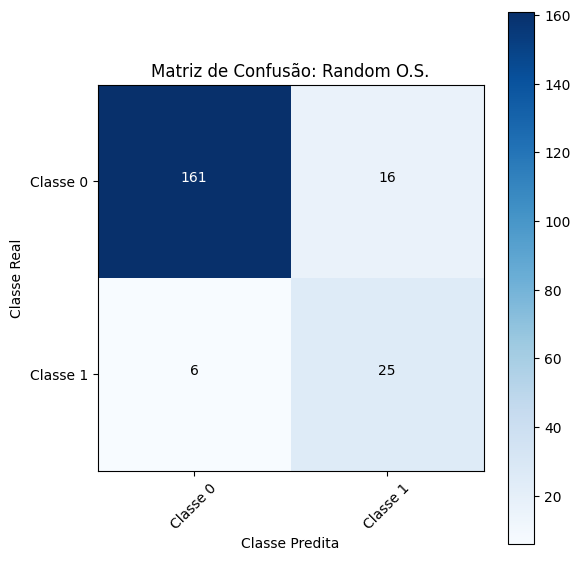

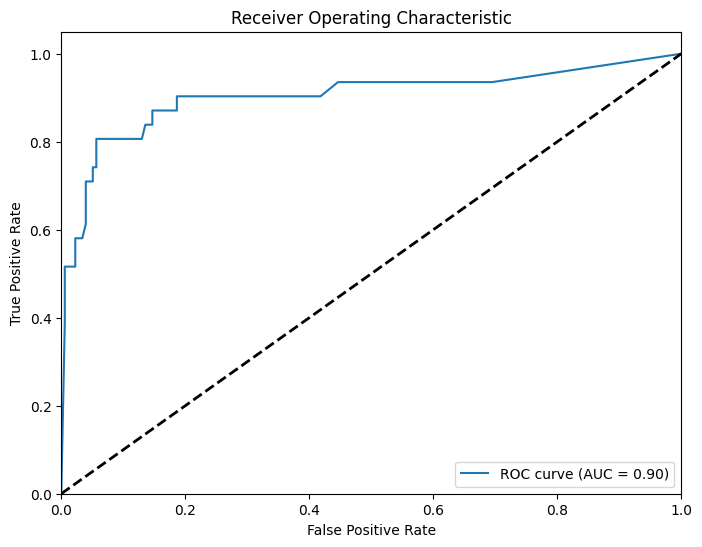

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']

X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar RandomOverSampling ou SMOTE
# Escolha o método de oversampling:
oversampler = RandomOverSampler(random_state=42)
#oversampler = SMOTE(random_state=42)

# Aplicar oversampling nos dados de treino
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring="f1")

# Exibir a tabela com métricas
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean F1_Score: {np.mean(cv_scores):.4f}")

# Relatório de Classificação por Classe
print("Relatório de Classificação por Classe:")
print(classification_report(y_test, y_pred))

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: Random O.S.')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Undersampling

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Relatório de Classificação por Classe:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       177
           1       0.44      0.84      0.58        31

    accuracy                           0.82       208
   macro avg       0.70      0.83      0.73       208
weighted avg       0.89      0.82      0.84       208



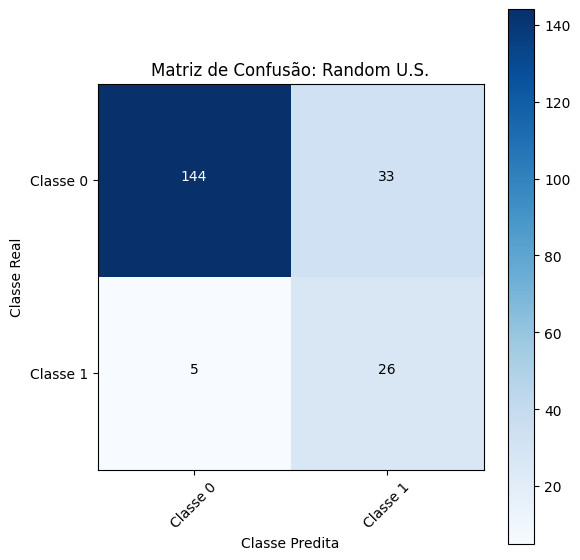

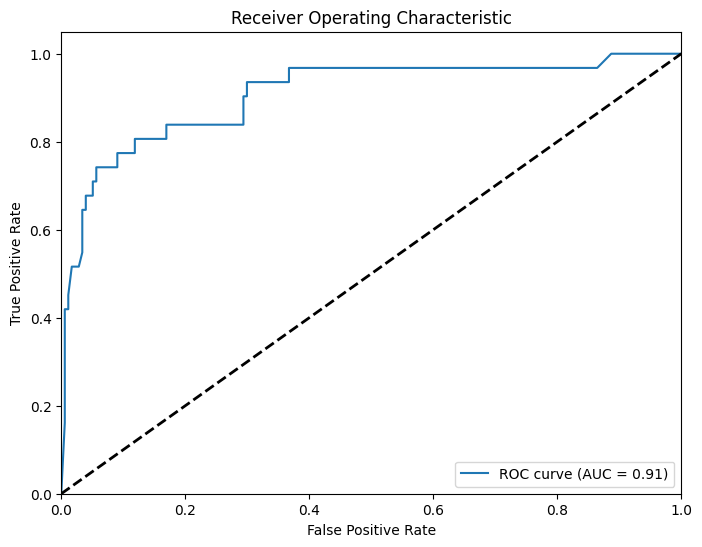

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar RandomUnderSampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados (undersampled)
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
print("Relatório de Classificação por Classe:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: Random U.S.')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']  # Substitua pelos nomes das suas classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# STANDARD SCALER

## PURO

Cross Validation Scores: [0.91222571 0.9153605  0.9153605  0.9153605  0.87421384]
Cross Validation Mean Accuracy: 0.9065

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       177
           1       0.88      0.74      0.81        31

    accuracy                           0.95       208
   macro avg       0.92      0.86      0.89       208
weighted avg       0.95      0.95      0.95       208


Tabela de Métricas:
       F1 Score  Precision  Recall  Accuracy
Value     0.807      0.885   0.742     0.947


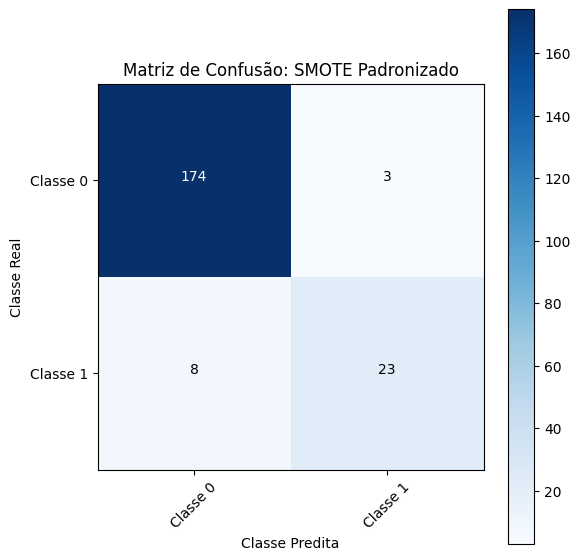

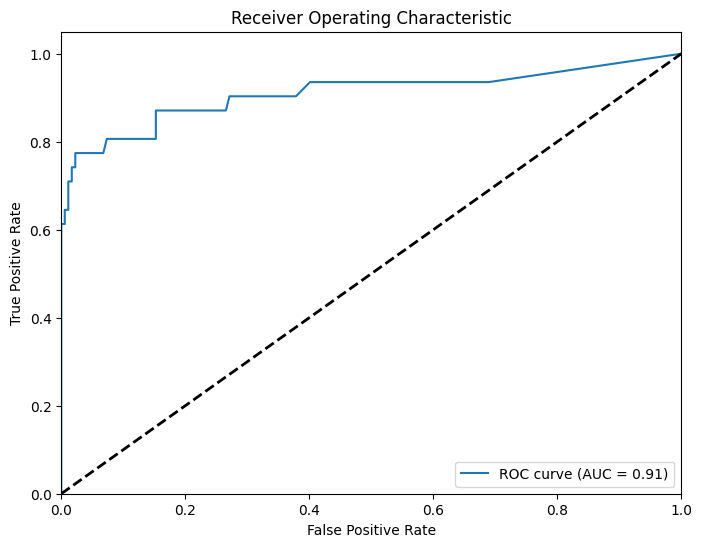

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']

X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Padronizar os dados com StandardScaler
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_standardized, y, cv=cv, scoring="accuracy")

# Mostrar resultados
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean Accuracy: {np.mean(cv_scores):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nTabela de Métricas:")
print(metrics_df)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: SMOTE Padronizado')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## SMOTE

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross Validation Scores: [0.9125     0.925      0.91875    0.90625    0.91823899 0.91194969
 0.91823899 0.91194969 0.89308176 0.90566038]
Cross Validation Mean Accuracy: 0.9122

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       177
           1       0.74      0.74      0.74        31

    accuracy                           0.92       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.92      0.92      0.92       208


Tabela de Métricas:
       F1 Score  Precision  Recall  Accuracy
Value     0.742      0.742   0.742     0.923


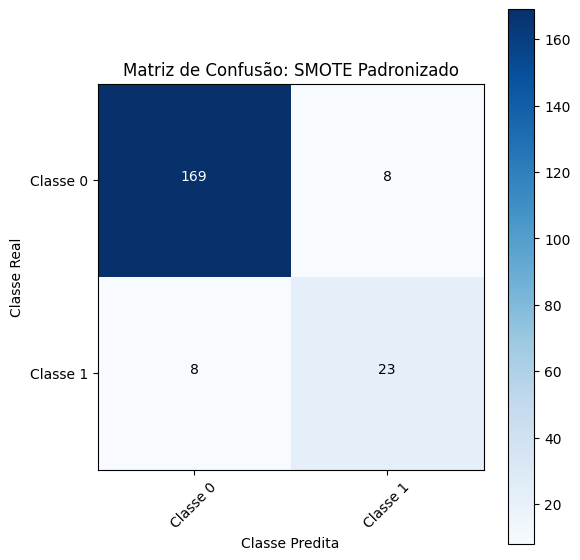

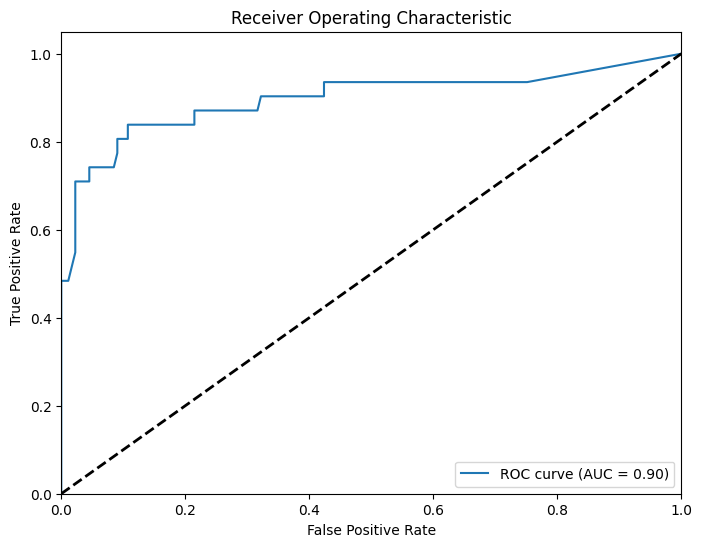

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']

X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Padronizar os dados com StandardScaler
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar oversampling (escolha o método: SMOTE ou RandomOverSampler)
# oversampler = RandomOverSampler(random_state=42)
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_standardized, y, cv=cv, scoring="accuracy")

# Mostrar resultados
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean Accuracy: {np.mean(cv_scores):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nTabela de Métricas:")
print(metrics_df)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: SMOTE Padronizado')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# RandomOverSampler

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Cross Validation Scores: [0.91222571 0.9153605  0.9153605  0.9153605  0.87421384]
Cross Validation Mean Accuracy: 0.9065

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       177
           1       0.61      0.81      0.69        31

    accuracy                           0.89       208
   macro avg       0.79      0.86      0.82       208
weighted avg       0.91      0.89      0.90       208


Tabela de Métricas:
       F1 Score  Precision  Recall  Accuracy
Value     0.694      0.610   0.806     0.894


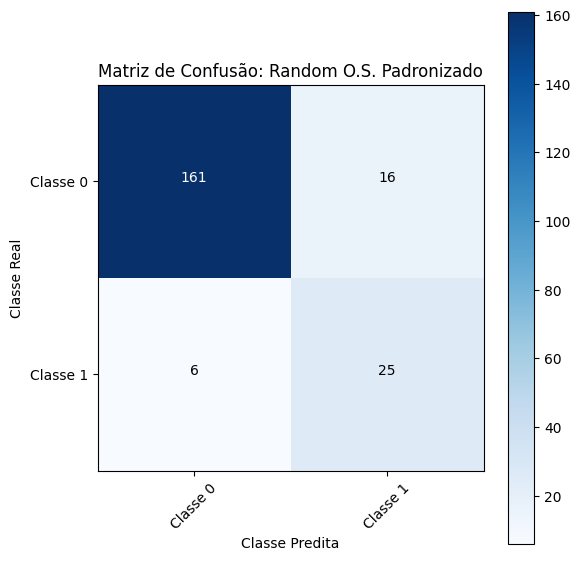

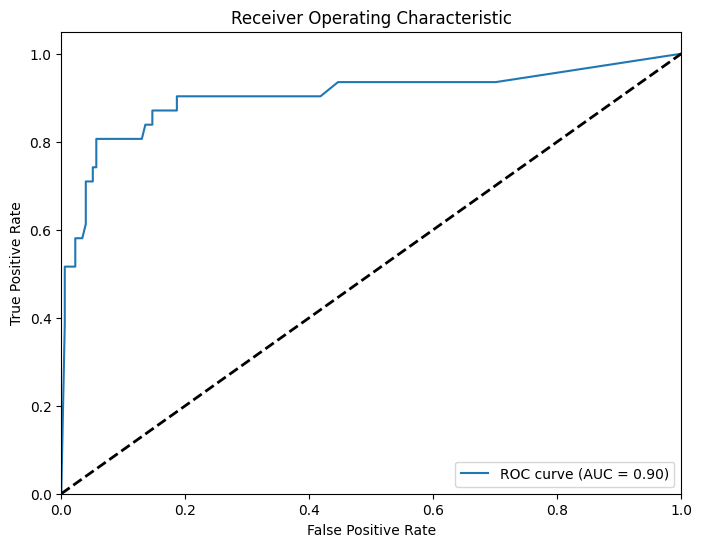

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']

X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Padronizar os dados com StandardScaler
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar oversampling (escolha o método: SMOTE ou RandomOverSampler)
oversampler = RandomOverSampler(random_state=42)
#oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_standardized, y, cv=cv, scoring="accuracy")

# Mostrar resultados
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean Accuracy: {np.mean(cv_scores):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nTabela de Métricas:")
print(metrics_df)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: Random O.S. Padronizado')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## RANDOmUNDErSAMPLER

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Cross Validation Scores: [0.91222571 0.9153605  0.9153605  0.9153605  0.87421384]
Cross Validation Mean Accuracy: 0.9065

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       177
           1       0.44      0.84      0.58        31

    accuracy                           0.82       208
   macro avg       0.70      0.83      0.73       208
weighted avg       0.89      0.82      0.84       208


Tabela de Métricas:
       F1 Score  Precision  Recall  Accuracy
Value     0.578      0.441   0.839     0.817


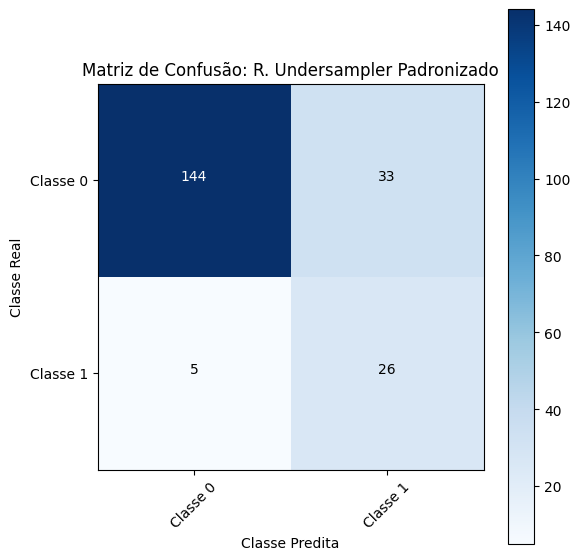

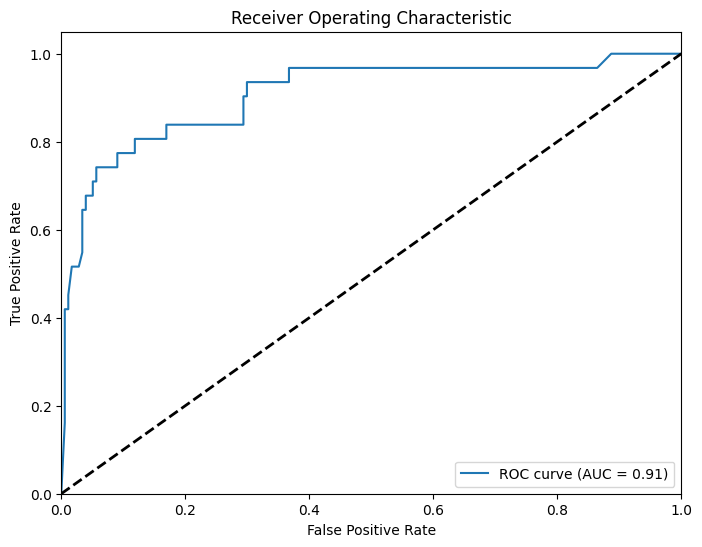

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Padronizar os dados com StandardScaler
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar oversampling (escolha o método: SMOTE ou RandomOverSampler)
undersampler = RandomUnderSampler(random_state=42)
#oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo com dados balanceados
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
metrics = {
    "F1 Score": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
}

metrics_df = pd.DataFrame(metrics, index=["Value"])

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_standardized, y, cv=cv, scoring="accuracy")

# Mostrar resultados
print("Cross Validation Scores:", cv_scores)
print(f"Cross Validation Mean Accuracy: {np.mean(cv_scores):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nTabela de Métricas:")
print(metrics_df)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: R. Undersampler Padronizado')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Plotar a curva ROC AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# SMOTEENN

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       177
           1       0.47      0.84      0.60        31

    accuracy                           0.84       208
   macro avg       0.72      0.84      0.75       208
weighted avg       0.89      0.84      0.85       208



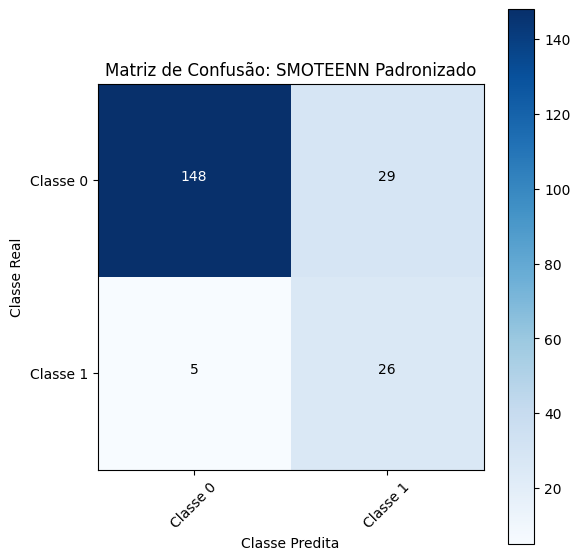

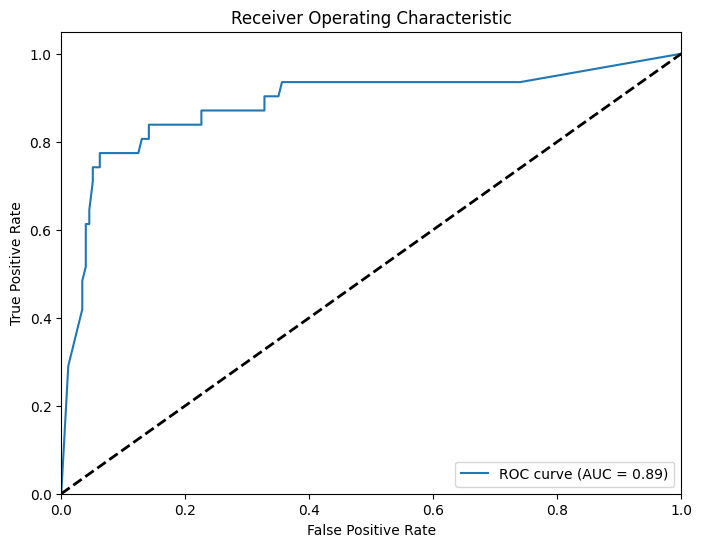

In [36]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Padronizar os dados com StandardScaler
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Aplicar SMOTEENN para balanceamento
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão: SMOTEENN Padronizado')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']  # Substitua pelos nomes das suas classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Curva ROC AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### OPTUNA

In [37]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [39]:
# Defina a proporção de importância
Peso_FN = 1  # Importância relativa de minimizar falsos negativos
Peso_FP = 1  # Importância relativa de minimizar falsos positivos

def calcular_custo_ponderado(y_true, y_pred):
  """Calcula o custo ponderado com base na matriz de confusão e na proporção."""
  cm = confusion_matrix(y_true, y_pred)
  FP = cm[0, 1]  # Falsos positivos (classe 0 prevista como 1)
  FN = cm[1, 0]  # Falsos negativos (classe 1 prevista como 0)
  return (FP * Peso_FP) + (FN * Peso_FN)

[I 2024-12-24 17:28:51,339] A new study created in memory with name: no-name-24b12812-8b28-4ffc-a299-f0b075cee238


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-12-24 17:28:53,049] Trial 0 finished with value: 22.2 and parameters: {'n_estimators': 70, 'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 7, 'max_features': 'log2', 'criterion': 'entropy', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 22.2.
[I 2024-12-24 17:28:54,665] Trial 1 finished with value: 22.6 and parameters: {'n_estimators': 50, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_features': 'sqrt', 'criterion': 'log_loss', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 22.2.
[I 2024-12-24 17:28:59,933] Trial 2 finished with value: 23.0 and parameters: {'n_estimators': 130, 'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_features': 'sqrt', 'criterion': 'entropy', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 22.2.
[I 2024-12-24 17:29:01,348] Trial 3 finished with value: 23.6 and parameters: {'n_estimators': 50, 'max_depth': 18, 'min_samples_leaf': 

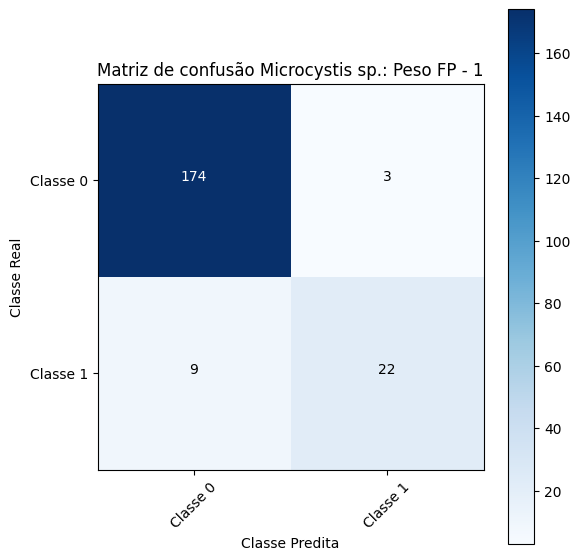

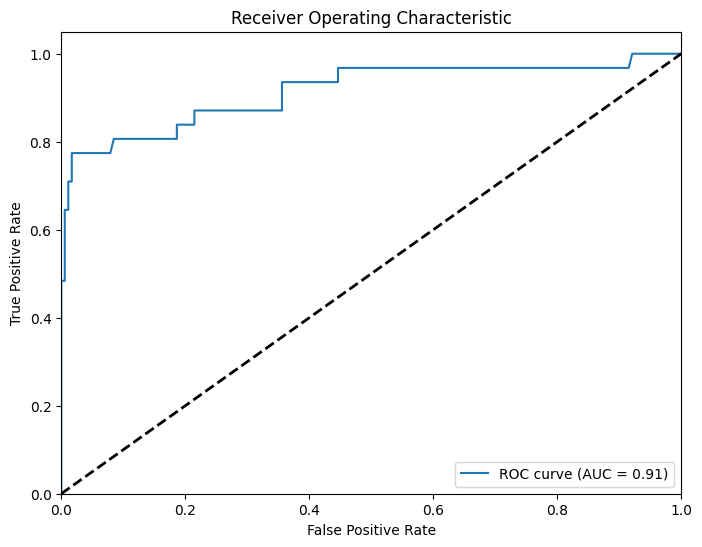

In [41]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Divisão dos dados antes do oversampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Função objetivo para otimizar
def objective(trial):
    # Hiperparâmetros sugeridos pelo Optuna
    n_estimators = trial.suggest_int('n_estimators', 50, 150, step=20)
    max_depth = trial.suggest_int('max_depth', 8, 33, step=5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 9, step=1)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None])

    # Modelo Random Forest com os hiperparâmetros sugeridos
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        bootstrap=bootstrap,
        random_state=42,
        class_weight=class_weight,
        n_jobs=-1
    )
    # Validação cruzada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    custos_ponderados = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        rf_model.fit(X_fold_train, y_fold_train)
        y_pred = rf_model.predict(X_fold_val)
    # Calcular o custo ponderado
        custo_ponderado = calcular_custo_ponderado(y_fold_val, y_pred)
        custos_ponderados.append(custo_ponderado)
    # Retornar a média dos F1-Scores weighted
    return np.mean(custos_ponderados)

# Otimização com Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Resultados
print("Melhores Hiperparâmetros:", study.best_params)

# Treinar o modelo com os melhores parâmetros
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar as métricas no conjunto de teste
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Matriz de confusão Microcystis sp.: Peso FP - {Peso_FP}')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Curva ROC AUC
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# {'n_estimators': 130, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 'log2', 'criterion': 'log_loss', 'bootstrap': True,  'class_weight': None}

# {'n_estimators': 190, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False, 'class_weight': None}


Tabela de Métricas:
       F1 Score  Precision  Recall  Accuracy
Value     0.842      0.923   0.774     0.957


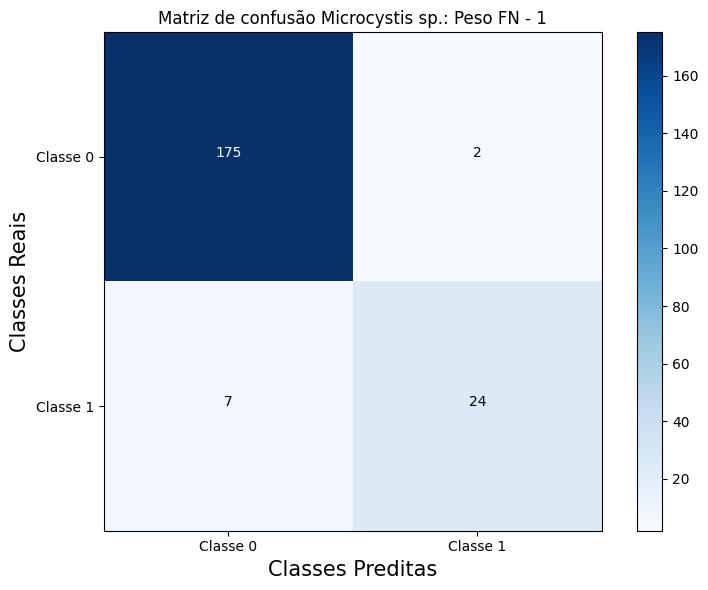

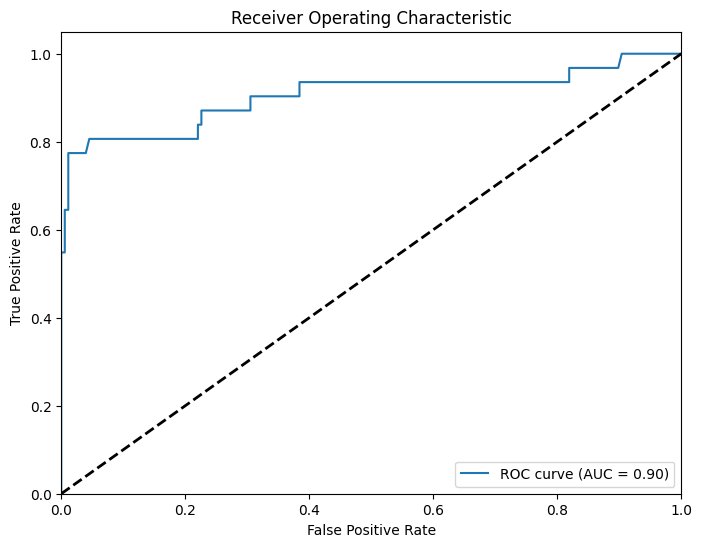

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Features selecionadas e target
selected_features = ['Verao','Delta T', 'pH', 'SolDissolvidosTotais', 'Turbidez']
X = df_micro_0e1[selected_features]
y = df_micro_0e1['Classe']

# Divisão em treino e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.23, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-(0.1/0.23), stratify=y_temp, random_state=42)

# Treinar o modelo RandomForest com hiperparâmetros padrão (sem padronização e sem undersampling)
rf_model = RandomForestClassifier(
           n_jobs=-1,
           bootstrap=True,
           max_features='sqrt',
           max_depth=8,
           n_estimators=100,
           min_samples_leaf=1,
           min_samples_split=2,
           criterion='log_loss',
           class_weight={0:1,1:1.5},
           random_state=42)
rf_model.fit(X_train, y_train) # Treinando com os dados crus, sem pré-processamento

# Previsão no conjunto de teste
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Avaliar métricas
metrics = {
    "F1 Score": f1_score(y_test, y_pred, pos_label=1),
    "Precision": precision_score(y_test, y_pred, pos_label=1),
    "Recall": recall_score(y_test, y_pred, pos_label=1),
    "Accuracy": accuracy_score(y_test, y_pred)
}
metrics_df = pd.DataFrame(metrics, index=["Value"])
print("\nTabela de Métricas:")
print(metrics_df)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Matriz de confusão Microcystis sp.: Peso FN - {Peso_FN}')
plt.colorbar()
classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classes Reais', fontsize=15)
plt.xlabel('Classes Preditas', fontsize=15)
plt.tight_layout()
plt.show()

# Curva ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()